# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Connet-definitions" data-toc-modified-id="Connet-definitions-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Connet definitions</a></div><div class="lev2 toc-item"><a href="#Default-boxes" data-toc-modified-id="Default-boxes-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Default boxes</a></div><div class="lev2 toc-item"><a href="#center-to-coords" data-toc-modified-id="center-to-coords-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>center to coords</a></div><div class="lev2 toc-item"><a href="#Get-prediction-boxes" data-toc-modified-id="Get-prediction-boxes-04"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Get prediction boxes</a></div><div class="lev2 toc-item"><a href="#Draw-pred-boxes" data-toc-modified-id="Draw-pred-boxes-05"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Draw pred boxes</a></div><div class="lev2 toc-item"><a href="#Calculate-IOU-score-and-find-matches" data-toc-modified-id="Calculate-IOU-score-and-find-matches-06"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>Calculate IOU score and find matches</a></div><div class="lev2 toc-item"><a href="#Normalize-shifts" data-toc-modified-id="Normalize-shifts-07"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>Normalize shifts</a></div><div class="lev2 toc-item"><a href="#Regression-Loss" data-toc-modified-id="Regression-Loss-08"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Regression Loss</a></div><div class="lev2 toc-item"><a href="#Compute-regression-loss" data-toc-modified-id="Compute-regression-loss-09"><span class="toc-item-num">0.9&nbsp;&nbsp;</span>Compute regression loss</a></div><div class="lev2 toc-item"><a href="#Everything-connected" data-toc-modified-id="Everything-connected-010"><span class="toc-item-num">0.10&nbsp;&nbsp;</span>Everything connected</a></div>

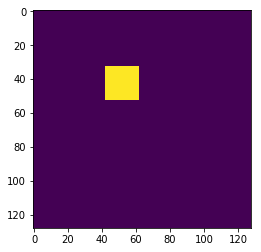

In [1]:
import chainer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import random 
from chainer.functions import log, hstack, huber_loss

# %matplotlib notebook
def get_single_image(): 
    
    image = np.zeros((1,3,128,128), dtype=np.float32)

    gts = []

    for i in range(1):
        # Choose random coordinate, this can also be run in a loop
        width = 20
        height = 20
        pos_r = np.random.randint(10, 60)
        pos_c = np.random.randint(10, 60)
        image[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
        #print(pos_r, pos_c)

        cx = pos_c #+ width/2.0
        cy = pos_r #+ height/2.0

        box = [cx, cy, width, height, 1, 0]

        gts.append(box)

    # Create ground truth object
    gts2 = chainer.Variable(np.array(gts, dtype=np.float32))
    return gts2, image 


gt, img  = get_single_image()
for i in range(1):
    # Initialize the image
    
    # Visualize the entire thing
    plt.imshow(img[0,0,:,:])
    plt.show()

## Connet definitions 

In [2]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l4=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.max_pooling_2d(h1, 2)
        h3 = F.relu(self.l2(h2))
#         h4 = F.max_pooling_2d(h3, 2)
#         h5 = F.relu(self.l3(h4))
#         h6 = F.max_pooling_2d(h5, 2)
#         h7 = F.relu(self.l4(h6))
        
        return self.l3(F.sigmoid(h3))

In [3]:
class BoxNet(Chain):
    def __init__(self, predictor):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        self.predictor = predictor
        
    def __call__(self, x):
        h1 = self.l1(self.predictor(x))
        return h1
    
convnet = ConvNet()
boxnet = BoxNet(ConvNet())
fm = convnet(img)
shifts = boxnet(img)
shifts= shifts[:,:,8,8]
shifts =F.reshape(shifts,[1,6,1,1])


## Default boxes 

In [4]:

def defaultgen(I, F, width, height):
    """
    Generates an array of default boxes: Chainer TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    scale = (I.shape[2] / F.shape[2])
    offset = np.ones((2,F.shape[2],F.shape[3]), dtype=np.float32)
    iterator = np.flip(np.indices((F.shape[2],F.shape[3])), axis=0).astype(np.float32)
    
    xys = offset * ((scale-1)/2) + iterator * scale
    xys = np.moveaxis(xys,0,2)
    ws = np.full((F.shape[2],F.shape[3],1), width, dtype=np.float32)
    hs = np.full((F.shape[2],F.shape[3],1), height,dtype=np.float32)
    class_scores = np.zeros((F.shape[2],F.shape[3],2), dtype=np.float32)
    db = np.dstack([xys, ws, hs, class_scores])
   
    db = db[8,8,:]
    db = db.reshape([1,1,6])
    
    return chainer.Variable(db.reshape((db.shape[0] * db.shape[1], 6)))


In [5]:
def_boxes=defaultgen(img, fm, 50,50 )

In [6]:
def_boxes

variable([[ 16.5,  16.5,  50. ,  50. ,   0. ,   0. ]])

## center to coords


In [7]:
def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]-box[3]/2.0, box[0]+box[2]/2.0, box[1]+box[3]/2.0, box[4], box[5]])
    return box_transformed



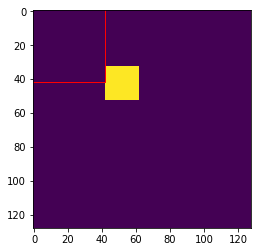

In [8]:
def draw_boxes(image, boxes):
    img = image
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box.data)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        ax.add_patch(p)

    plt.show()
draw_boxes(img, def_boxes)    

## Get prediction boxes 

In [9]:
def get_pred_boxes(shift_vals, default_boxes ): 
    """
    Get predicted boxes by combining shift values to default boxes
    Input: 

    shift_values : Shifts generated by the network  NDarray (None, Num of Default boxes, 4+num of classes)
    Default boxes  : Default boxes generated by the network NDarray (None, Num of Default boxes, 4+num of classes)

    Output: 

    Predicted boxes  : Predicted boxes, same shape as default boxes  NDarray (None, Num of Default boxes, 4+num of classes)

    """
    
    shift_val_shape= default_boxes.shape
    shift_vals= F.swapaxes(shift_vals,1,3)
    shift_vals= F.reshape(shift_vals,shift_val_shape)
    
    shifts = shift_vals 
    def_boxes= default_boxes
    
    
    cx_pred = (shifts[:,0]*def_boxes[:,2])+def_boxes[:,0]
    cy_pred = (shifts[:,1]*def_boxes[:,3])+def_boxes[:,1]
    
    H_pred = F.exp(shifts[:,3])*def_boxes[:,3]
    W_pred = F.exp(shifts[:,2])*def_boxes[:,2]
    
    class1 = shifts[:,4]
    class2 = shifts[:,5]
    
    
    pred_boxes = F.vstack((cx_pred,cy_pred,W_pred,H_pred, class1, class2))
    pred_boxes = F.transpose(pred_boxes)
    
    return  pred_boxes 

## Draw pred boxes

In [10]:
def draw_pred_boxes(prediction_boxes, default_boxes, shifts): 
    """Draw predicted boxes on the original image """
    
    pred_boxes= prediction_boxes
    def_boxes =default_boxes.data
     
    boxes = pred_boxes.data
    
    plt.figure()
    ax = plt.axes()

    for i in range(def_boxes.shape[0]):
        box = def_boxes[i]
        box2 =boxes[i]         
        
        box2cx = box2[0]
        box2cy = box2[1]
        
        box = center_to_coords(box)
        box2 = center_to_coords(box2)  
        
        ax.imshow(img[0,0,:,:])

        boxes = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        boxes2 = patches.Rectangle((box2cx, box2cx), box2[2]-box2[0], box2[3]-box2[1], fill=False, color = 'green')

        ax.add_patch(boxes)
        ax.add_patch(boxes2)


    plt.show()

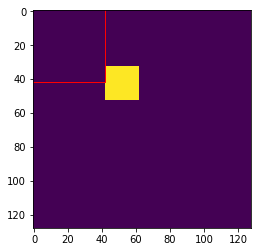

In [11]:

pred_boxes = get_pred_boxes(shifts, def_boxes)
draw_pred_boxes(pred_boxes, def_boxes, shifts)


## Calculate IOU score and find matches


## Normalize shifts 

In [12]:

def normalize_shift(box, def_box):
    """
    Scales down absolute shifts, % for centers, log for height and width.
    
    Args:
        box: 6x1 bounding box coordinates
        def_box: 6x1 reference box coordinates
        
    Returns:
        normalized_shift_vector: 4x1 normalized shift vector. Note that we discard the last 2 channels.
    """
    tx = (box[0] - def_box[0])/def_box[2]
    ty = (box[1] - def_box[1])/def_box[3]
    tw = log(box[2]/def_box[2])
    th = log(box[3]/def_box[3])
    
    return hstack([tx, ty, tw, th])
    

## Regression Loss 

In [13]:





def regression_loss(pred_box, gt_box, def_box):
    """
    Calculates regression loss between two boxes w.r.t a reference default box.
    
    Args:
        pred_box: 6x1 bounding box predicted by the network
        gt_box: 6x1 bounding box overlapping with pred_box
        def_box: 6x1 bounding box with same index as pred_box
        
    Returns:
        reg_loss: Scalar of huber loss between two vectors
    """
 
    pred_shift = normalize_shift(pred_box[0], def_box[0]).reshape((1, 4))
    gt_shift = normalize_shift(gt_box[0], def_box[0]).reshape((1, 4))
    xdiff = gt_shift- pred_shift 
    
    ydiff =F.absolute(xdiff) 
    ydiff= F.sum(ydiff)
    
    
    return ydiff.reshape(1)
    

In [14]:
loss_check = regression_loss(pred_boxes,gt, def_boxes)
loss_check


variable([ 4.31780338])

## Compute regression loss

In [15]:
def compute_loss(gt_boxes, pred_boxes, def_boxes):
    
    loss_class = chainer.Variable(np.array([0.], dtype=np.float32))
    loss_reg = chainer.Variable(np.array([0.], dtype=np.float32))
    
    gt_box, pred_box, def_box = gt_boxes, pred_boxes, def_boxes    
    loss_reg += regression_loss(pred_box, gt_box, def_box)
    
    return loss_reg

In [16]:
loss_value = compute_loss(gt, pred_boxes, def_boxes )
loss_value

variable([ 4.31780338])

## Everything connected 

  0%|          | 0/700 [00:00<?, ?it/s]

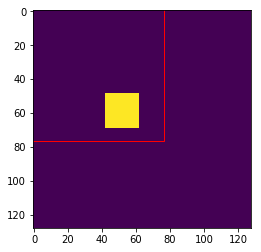

  0%|          | 3/700 [00:00<01:49,  6.34it/s]

pred box loc:   variable(-41.45446014404297) variable(20.04299545288086)
gt variable([[ 42.  49.  20.  20.   1.   0.]])


  7%|▋         | 49/700 [00:03<00:47, 13.60it/s]

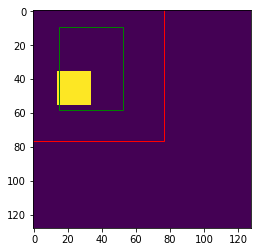

  8%|▊         | 53/700 [00:04<00:54, 11.96it/s]

pred box loc:   variable(33.349853515625) variable(33.8472900390625)
gt variable([[ 14.  36.  20.  20.   1.   0.]])


 14%|█▍        | 99/700 [00:07<00:42, 14.05it/s]

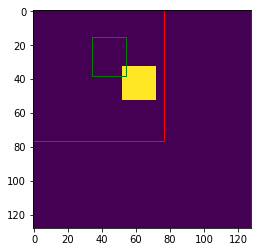

 15%|█▍        | 103/700 [00:07<00:48, 12.32it/s]

pred box loc:   variable(44.007877349853516) variable(26.675174713134766)
gt variable([[ 52.  33.  20.  20.   1.   0.]])


 21%|██▏       | 149/700 [00:11<00:43, 12.66it/s]

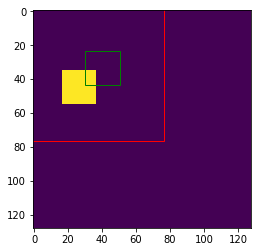

 22%|██▏       | 151/700 [00:11<00:53, 10.28it/s]

pred box loc:   variable(40.26464080810547) variable(33.6300048828125)
gt variable([[ 17.  35.  20.  20.   1.   0.]])


 28%|██▊       | 199/700 [00:15<00:35, 13.99it/s]

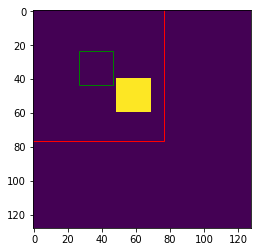

 29%|██▊       | 201/700 [00:15<00:46, 10.75it/s]

pred box loc:   variable(36.60808563232422) variable(33.53950119018555)
gt variable([[ 49.  40.  20.  20.   1.   0.]])


 36%|███▌      | 249/700 [00:19<00:32, 13.82it/s]

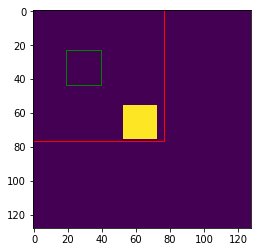

 36%|███▌      | 253/700 [00:19<00:37, 12.00it/s]

pred box loc:   variable(29.01012420654297) variable(33.07357406616211)
gt variable([[ 53.  56.  20.  20.   1.   0.]])


 43%|████▎     | 299/700 [00:22<00:28, 13.96it/s]

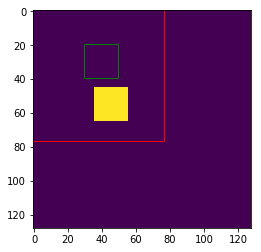

 43%|████▎     | 303/700 [00:23<00:32, 12.36it/s]

pred box loc:   variable(39.41532897949219) variable(29.214683532714844)
gt variable([[ 36.  45.  20.  20.   1.   0.]])


 50%|████▉     | 349/700 [00:26<00:28, 12.18it/s]

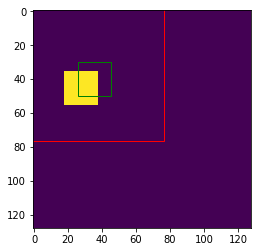

 50%|█████     | 353/700 [00:27<00:32, 10.53it/s]

pred box loc:   variable(35.630516052246094) variable(39.694000244140625)
gt variable([[ 18.  36.  20.  20.   1.   0.]])


 57%|█████▋    | 399/700 [00:30<00:21, 14.26it/s]

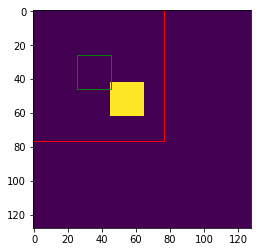

 57%|█████▋    | 401/700 [00:30<00:27, 11.00it/s]

pred box loc:   variable(35.437381744384766) variable(35.9348258972168)
gt variable([[ 45.  42.  20.  20.   1.   0.]])


 64%|██████▍   | 449/700 [00:34<00:17, 14.01it/s]

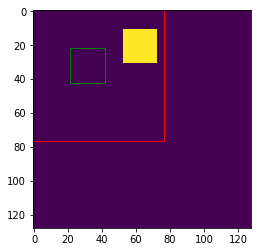

 64%|██████▍   | 451/700 [00:34<00:23, 10.60it/s]

pred box loc:   variable(31.462627410888672) variable(31.960050582885742)
gt variable([[ 53.  11.  20.  20.   1.   0.]])


 71%|███████▏  | 499/700 [00:38<00:14, 14.18it/s]

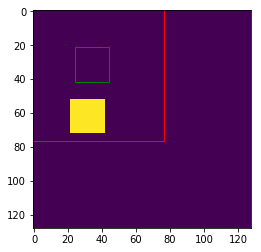

 72%|███████▏  | 503/700 [00:38<00:16, 11.78it/s]

pred box loc:   variable(34.33955383300781) variable(31.27096176147461)
gt variable([[ 22.  52.  20.  20.   1.   0.]])


 78%|███████▊  | 549/700 [00:42<00:10, 14.16it/s]

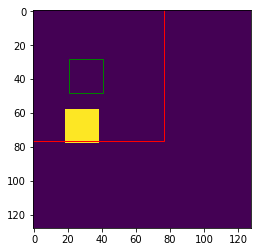

 79%|███████▉  | 553/700 [00:42<00:12, 12.15it/s]

pred box loc:   variable(30.395320892333984) variable(38.024818420410156)
gt variable([[ 19.  58.  20.  20.   1.   0.]])


 86%|████████▌ | 599/700 [00:45<00:07, 14.16it/s]

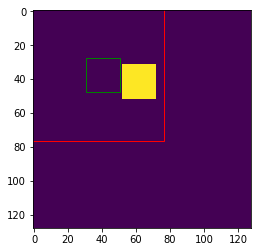

 86%|████████▌ | 603/700 [00:46<00:07, 12.23it/s]

pred box loc:   variable(40.59368896484375) variable(37.52509307861328)
gt variable([[ 52.  32.  20.  20.   1.   0.]])


 93%|█████████▎| 649/700 [00:49<00:03, 13.34it/s]

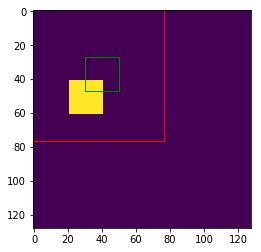

 93%|█████████▎| 653/700 [00:50<00:03, 11.80it/s]

pred box loc:   variable(39.97395324707031) variable(36.90534973144531)
gt variable([[ 21.  41.  20.  20.   1.   0.]])


100%|██████████| 700/700 [00:54<00:00, 12.96it/s]


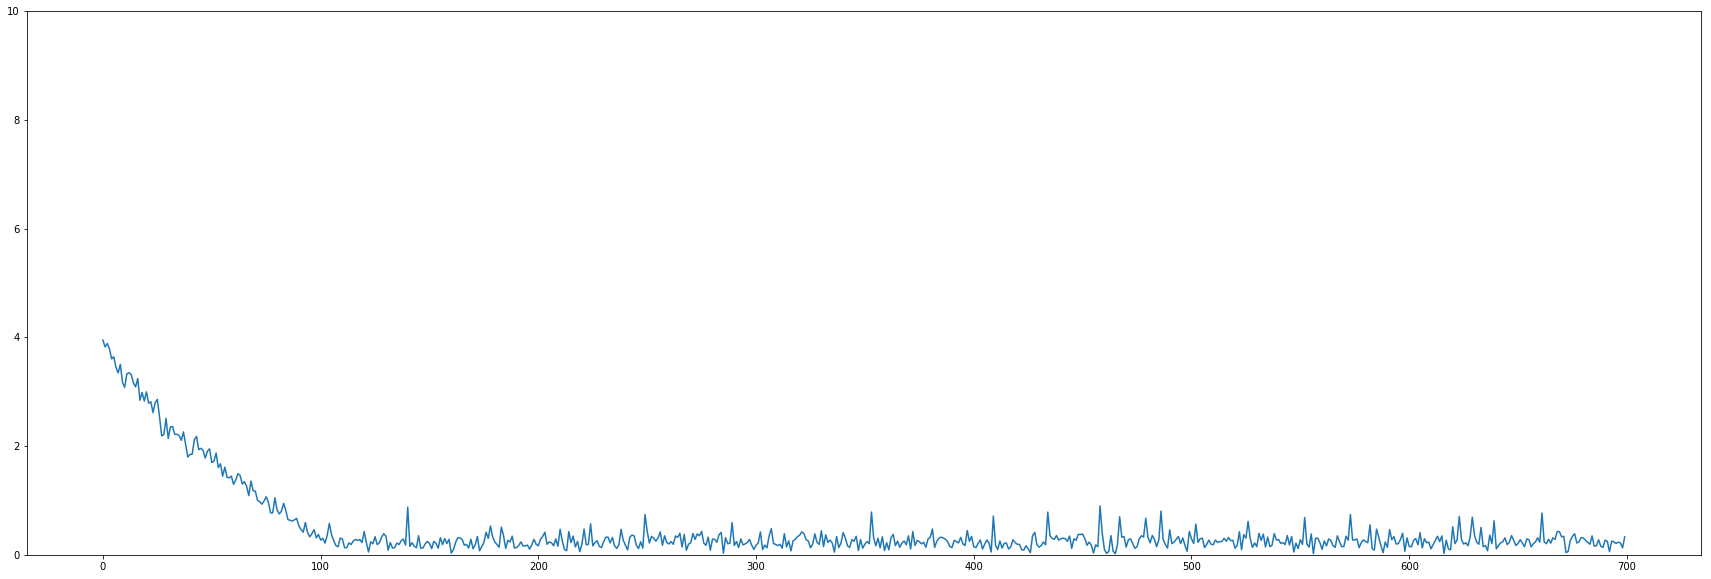

In [17]:
from chainer.optimizers import SGD,Adam,MomentumSGD
from tqdm import tqdm


boxnet = BoxNet(ConvNet())
#boxnet(img)

# optimizer =SGD(lr= 0.00004)
# optimizer = Adam(alpha=0.001)

optimizer =SGD(lr= 0.0004)
optimizer.setup(boxnet)
loss_history = []

for i in tqdm(range(700)):
 
    gt, img = get_single_image()
    

    # Initializing the network and computing the features and shifts
    #fm = convnet(img)
    shifts = boxnet(img)
    shifts= shifts[:,:,8,8]
    shifts =F.reshape(shifts,[1,6,1,1])
    
    
    #shifts.shape

    # Getting default_boxes and predictions
    # Forward pass ends here
    
    def_boxes = defaultgen(img, fm, 120,120)
    
    pred_boxes = get_pred_boxes(shifts, def_boxes)
#     print(pred_boxes)

    # Computing the loss
    boxnet.zerograds()
    loss = compute_loss(gt, pred_boxes, def_boxes)
    
    if i % 50 == 0:
        draw_pred_boxes(pred_boxes, def_boxes,shifts)
        print('pred box loc:  ' , pred_boxes[0][0],pred_boxes[0][1] )
        print('gt', gt)
    
    loss_history.append(loss.data[0])
    loss.backward()
    
    optimizer.update()

import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(range(len(loss_history)), loss_history)
plt.ylim([0,10])
plt.show()

In [18]:
loss_history

[3.949259,
 3.823158,
 3.8887246,
 3.7876244,
 3.6031899,
 3.6430578,
 3.4473729,
 3.3462725,
 3.5035052,
 3.1690712,
 3.0814226,
 3.3303223,
 3.3502033,
 3.3161716,
 3.165071,
 3.0896692,
 3.2425866,
 2.8438871,
 2.9872594,
 2.8278248,
 2.9972005,
 2.7886744,
 2.8163829,
 2.6152821,
 2.7948062,
 2.8603728,
 2.5380816,
 2.187577,
 2.2133417,
 2.508852,
 2.1408582,
 2.3530345,
 2.3600404,
 2.2172732,
 2.2175004,
 2.1913993,
 2.1067386,
 2.2605827,
 2.026149,
 1.7980845,
 1.8471648,
 1.8500481,
 2.1192446,
 2.1775641,
 1.9347968,
 1.9586962,
 1.921718,
 1.7789499,
 1.9064951,
 1.9492768,
 1.6981761,
 1.7231328,
 1.8720318,
 1.6054085,
 1.6734776,
 1.4473767,
 1.6115398,
 1.4248927,
 1.4154592,
 1.4476918,
 1.2962885,
 1.3752081,
 1.4923292,
 1.4629135,
 1.3027234,
 1.3448451,
 1.2604117,
 1.0882711,
 1.3559961,
 1.1798944,
 1.1704626,
 1.0038383,
 0.97739255,
 0.93131083,
 0.98854285,
 1.0668597,
 0.96860522,
 0.77191961,
 0.77112132,
 1.0494362,
 0.82299197,
 0.7519089,
 0.80225331,
 0.

In [19]:
pred_boxes

variable([[  4.15078583e+01,   3.84392548e+01,   1.99186840e+01,
             2.02071171e+01,  -1.23181371e-02,  -3.20176840e-01]])

In [20]:
gt

variable([[ 56.,  15.,  20.,  20.,   1.,   0.]])

In [21]:

25-17

8